In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchvision import models, transforms
from torchvision.utils import make_grid

In [3]:
from zse.models.adain_module import AdaINLitModule2D
from zse.models.components.adain_net import AdaINNet
from zse.models.components.adain_unet import AdaINUNet
from zse.models.components.unet import UNet
from zse.utils.data_utils import read_h5

In [4]:
def plot_cross_section(z_stack, idx, z_depth, fname=None):
    z_stack = z_stack.detach().clone().cpu().squeeze(1)
    z, y, x = idx
    # yx
    a = z_stack[z, :, :]
    # zx = top
    b = z_stack[:, y, :]
    # yz = right
    c = z_stack[:, :, x].transpose(0, 1)

    fig, main_ax = plt.subplots(figsize=(10, 10))
    divider = make_axes_locatable(main_ax)
    pad = 0.01
    if z_depth > 20:
        pad *= 10
    top_ax = divider.append_axes("top", 1, pad=pad, sharex=main_ax)
    right_ax = divider.append_axes("right", 1, pad=pad, sharey=main_ax)

    main_ax.tick_params(colors='black', which='both')
    top_ax.tick_params(colors='black', which='both')
    right_ax.tick_params(colors='black', which='both')

    ticks = [i*10 for i in range(round(z_depth/10))] + [z_depth-1]
    top_ax.set_yticks(ticks)
    right_ax.set_xticks(ticks)

    main_ax.xaxis.set_tick_params(color='black')
    top_ax.xaxis.set_tick_params(labelbottom=False, color='black')
    right_ax.yaxis.set_tick_params(labelleft=False, color='black')

    main_ax.set_xlabel('X', color='black')
    main_ax.set_ylabel('Y', color='black')
    top_ax.set_ylabel('Z', color='black')
    right_ax.set_xlabel('Z', color='black')

    main_ax.imshow(a, cmap='gray', vmin=0, vmax=1, origin='lower')
    top_ax.imshow(b, cmap='gray', vmin=0, vmax=1)
    right_ax.imshow(c, cmap='gray', vmin=0, vmax=1)

    main_ax.axhline(y, color='b')
    main_ax.axvline(x, color='b')
    top_ax.axhline(z, color='b')
    top_ax.axvline(x, color='b')
    right_ax.axhline(y, color='b')
    right_ax.axvline(z, color='b')
    main_ax.autoscale(enable=False)
    right_ax.autoscale(enable=False)
    top_ax.autoscale(enable=False)
    right_ax.set_xlim(right=z_depth-0.5)
    top_ax.set_ylim(bottom=z_depth-0.5)

    main_ax.invert_yaxis()
    top_ax.invert_yaxis()

    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.1)

In [ ]:
def save_nib(stack, path, fname):
    stack = stack.mul(255).byte().squeeze().permute(1, 2, 0).detach().cpu().numpy()
    os.makedirs(f"{path}", exist_ok=True)

    nib_image = nib.Nifti1Image(stack, np.identity(4))
    nib.nifti1.save(nib_image, f"{path}/{fname}.nii")

In [7]:
def gen_qualitative(ckpt_path, model, name, z_thickness, fname, stack, x, y, idx):
    assert model in ["adain_unet", "adain", "unet"]
    module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=model_to_net[model]).to(device)
    module.freeze()
    module.eval()
    style = stack[(stack.size(0)-1)//2].unsqueeze(0).expand(z_thickness, -1, -1, -1)
    out = module({"content": stack.to(device), "style": style.to(device)})
    save_nib(out, f"{dest}/{z_thickness}/nib", f"{fname[:-5]}_out_{name}")
    plot_cross_section(out[:, :, y:y+256, x:x+256], idx, z_thickness, f"{dest}/{z_thickness}/{fname[:-5]}_out_{name}.png")
    out.detach().cpu()
    module.cpu()

In [8]:
home = "/p/fastdata/bigbrains/personal/crijnen1"
data_root = f"{home}/data"
zse_path = f"../.."
model_path = f"{zse_path}/models"
torch.hub.set_dir(f"{home}/models")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [9]:
path = f"{data_root}/bigbrain_1micron/d/test/blurry"
dest = f"{zse_path}/notebooks/bigbrain_1micron/qualitative"
file_names = ["B21_0371_y39740_x18220.hdf5",
              "B21_0374_y40628_x11722.hdf5",
              "B21_1555_25291_72614.hdf5",
              "B21_1961_y86767_x27492.hdf5",
              "B21_2670_37387_76291.hdf5",
              "B21_3716_y73642_x37800.hdf5",
              "B21_4301_y43018_x87196.hdf5",]

In [10]:
vgg19 = models.vgg19(pretrained=True)
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model_to_net = {
    "adain_unet": AdaINUNet(vgg19, norm),
    "adain": AdaINNet(vgg19, norm),
    "unet": UNet(vgg19, norm),
}

In [11]:
to_tensor = transforms.ToTensor()
stacks_20 = {f: to_tensor(read_h5(f"{path}/{f}".replace("/d/", "/20/"))).unsqueeze(1) for f in file_names}
stacks_29 = {f: to_tensor(read_h5(f"{path}/{f}".replace("/d/", "/29/"))).unsqueeze(1) for f in file_names}

In [12]:
for f, stack in stacks_20.items():
    save_nib(stack, f"{dest}/20/nib", f"{f[:-5]}_content")

In [13]:
for f, stack in stacks_29.items():
    save_nib(stack, f"{dest}/29/nib", f"{f[:-5]}_content")

In [12]:
# fname = "B21_1961_y86767_x27492.hdf5"
fname = "B21_0371_y39740_x18220.hdf5"

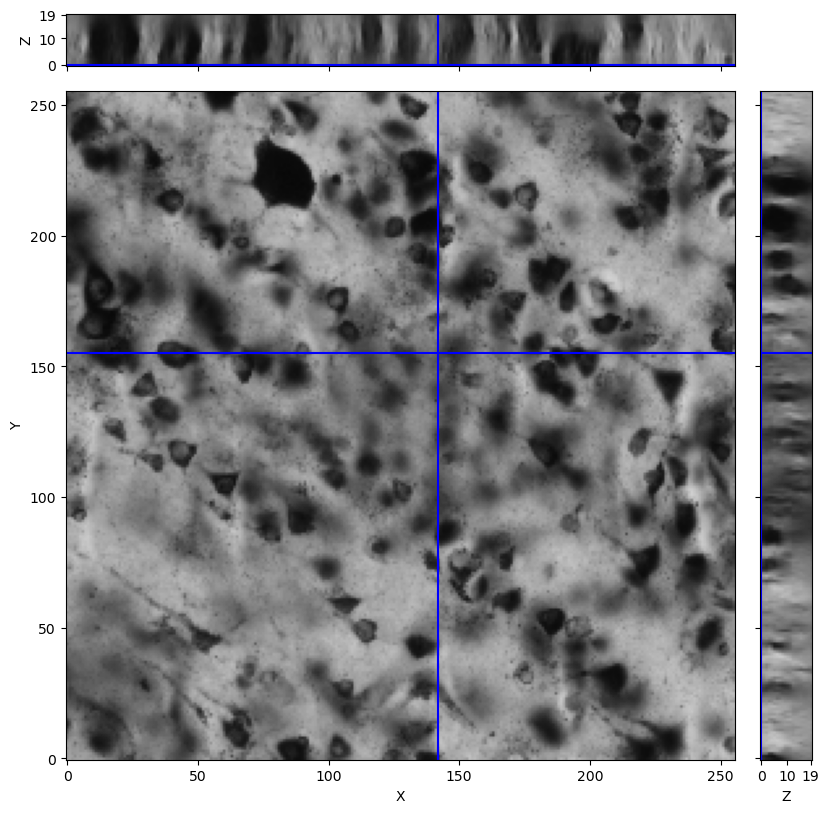

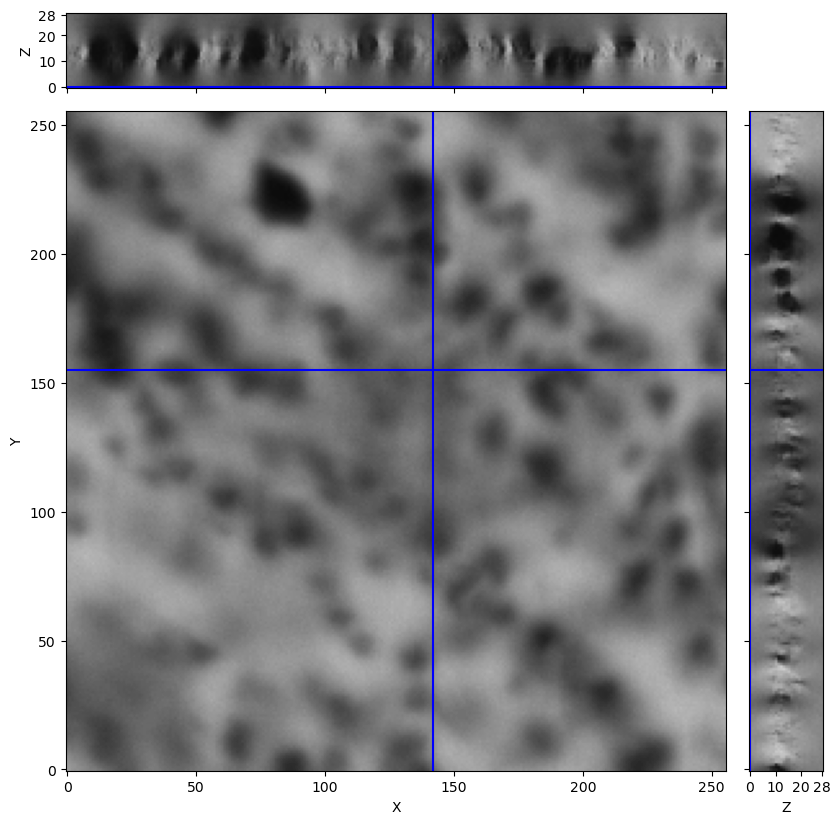

In [13]:
# y = 0
# x = 0
# idx_20 = (0, 190, 110)
# idx_29 = (0, 190, 110)
y = 256
x = 0
idx_20 = (0, 155, 142)
idx_29 = (0, 155, 142)

# offset = xs, ys = (0, 256)
plot_cross_section(stacks_20[fname][:, :, y:y+256, x:x+256], idx_20, 20, f"{dest}/20/{fname[:-5]}_content.png")
plot_cross_section(stacks_29[fname][:, :, y:y+256, x:x+256], idx_29, 29, f"{dest}/29/{fname[:-5]}_content.png")

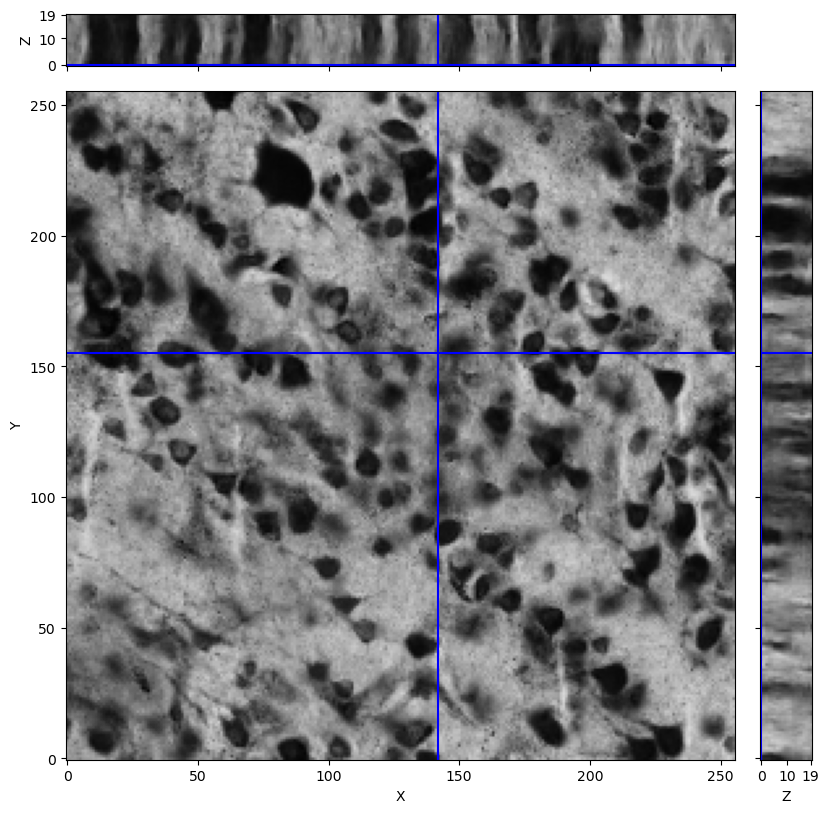

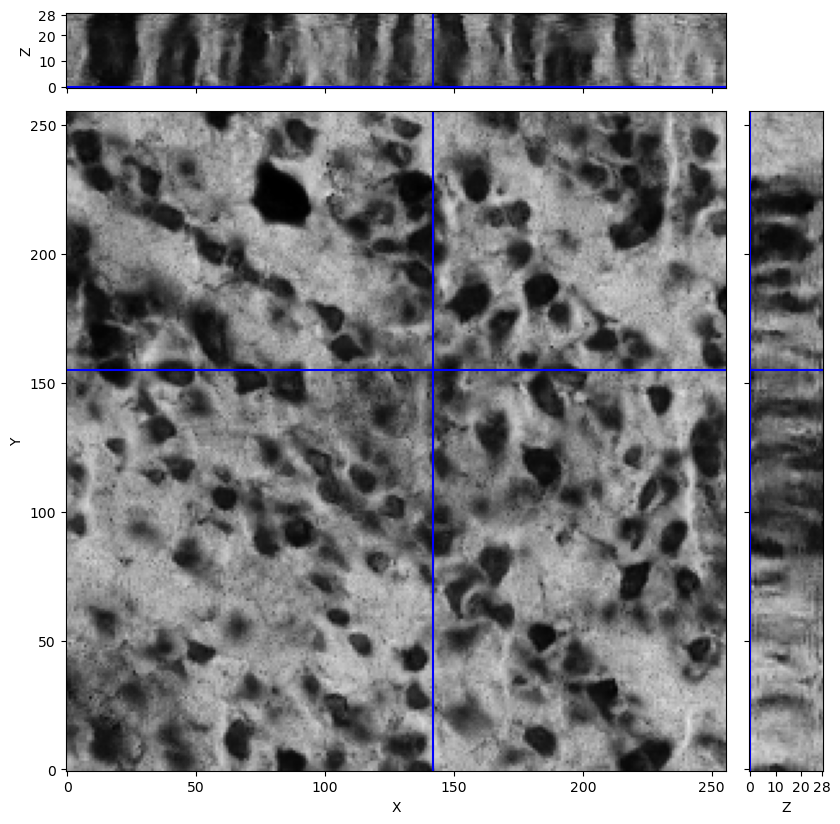

In [14]:
ckpt_path = f"{model_path}/brain/adain_unet_2d_best.ckpt"
gen_qualitative(ckpt_path, "adain_unet", "adain_unet_2d", 20, fname, stacks_20[fname], x, y, idx_20)
gen_qualitative(ckpt_path, "adain_unet", "adain_unet_2d", 29, fname, stacks_29[fname], x, y, idx_29)

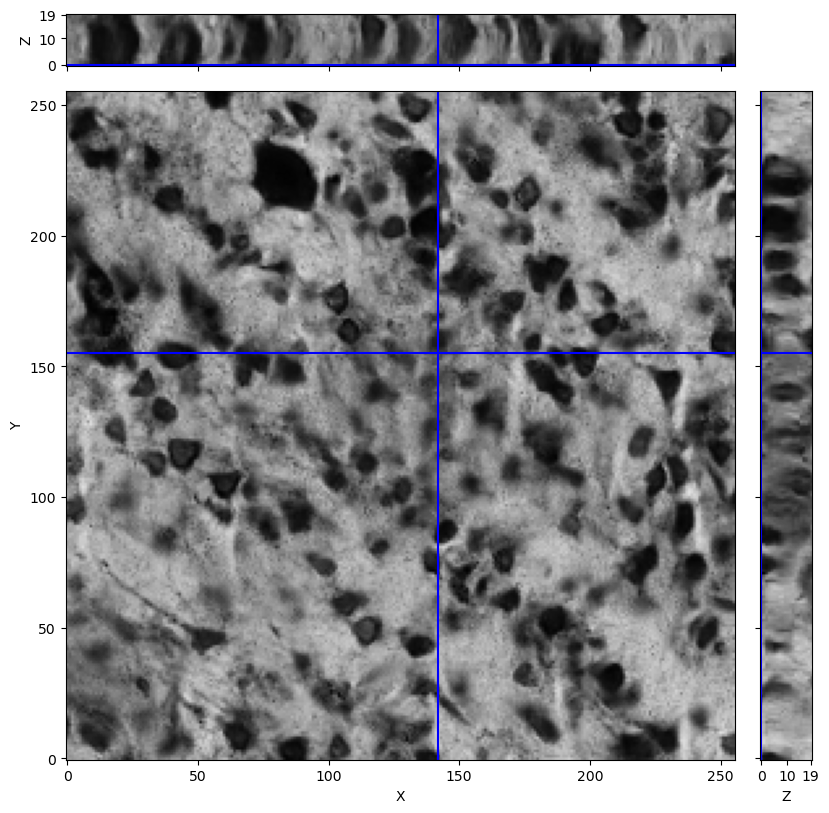

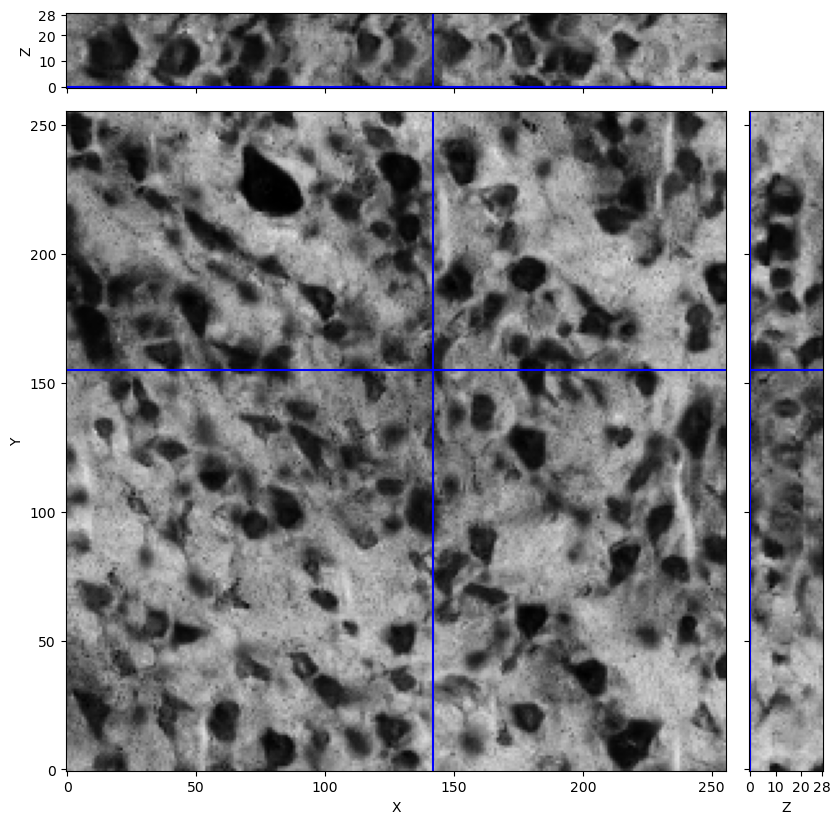

In [15]:
ckpt_path = f"{model_path}/brain/adain_unet_3d_best.ckpt"
gen_qualitative(ckpt_path, "adain_unet", "adain_unet_3d", 20, fname, stacks_20[fname], x, y, idx_20)
gen_qualitative(ckpt_path, "adain_unet", "adain_unet_3d", 29, fname, stacks_29[fname], x, y, idx_29)

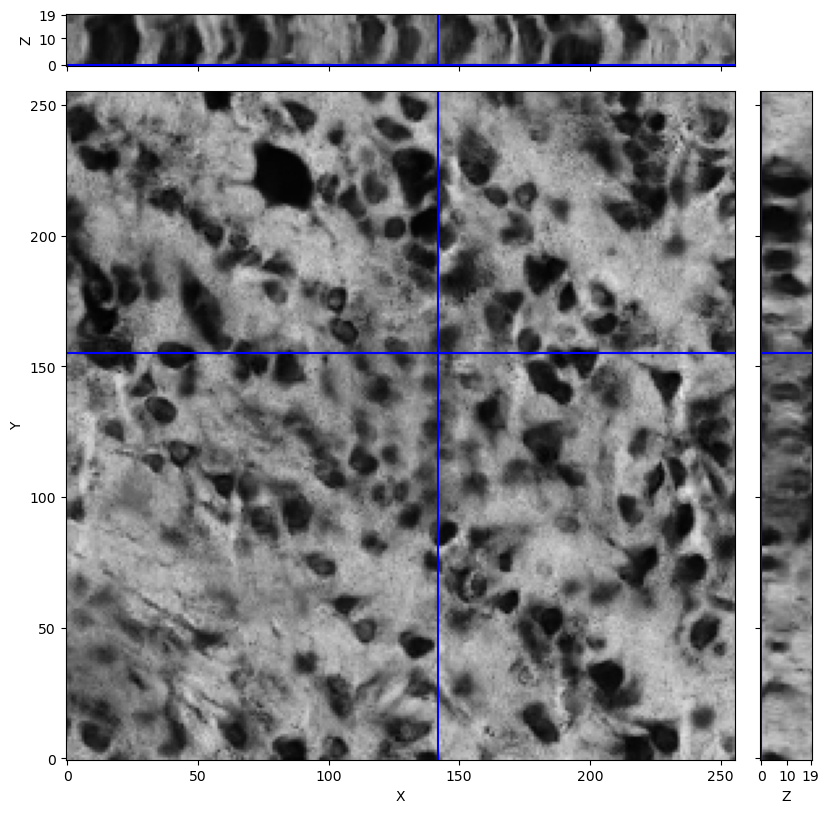

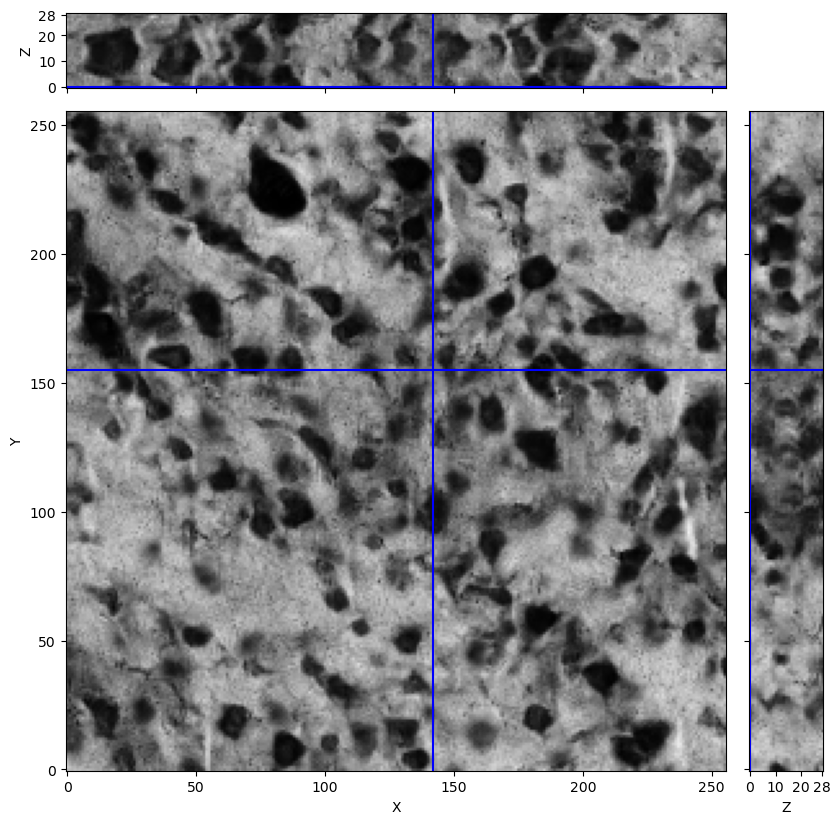

In [16]:
ckpt_path = f"{model_path}/brain/adain_unet_3ds_best.ckpt"
gen_qualitative(ckpt_path, "adain_unet", "adain_unet_3d_small", 20, fname, stacks_20[fname], x, y, idx_20)
gen_qualitative(ckpt_path, "adain_unet", "adain_unet_3d_small", 29, fname, stacks_29[fname], x, y, idx_29)

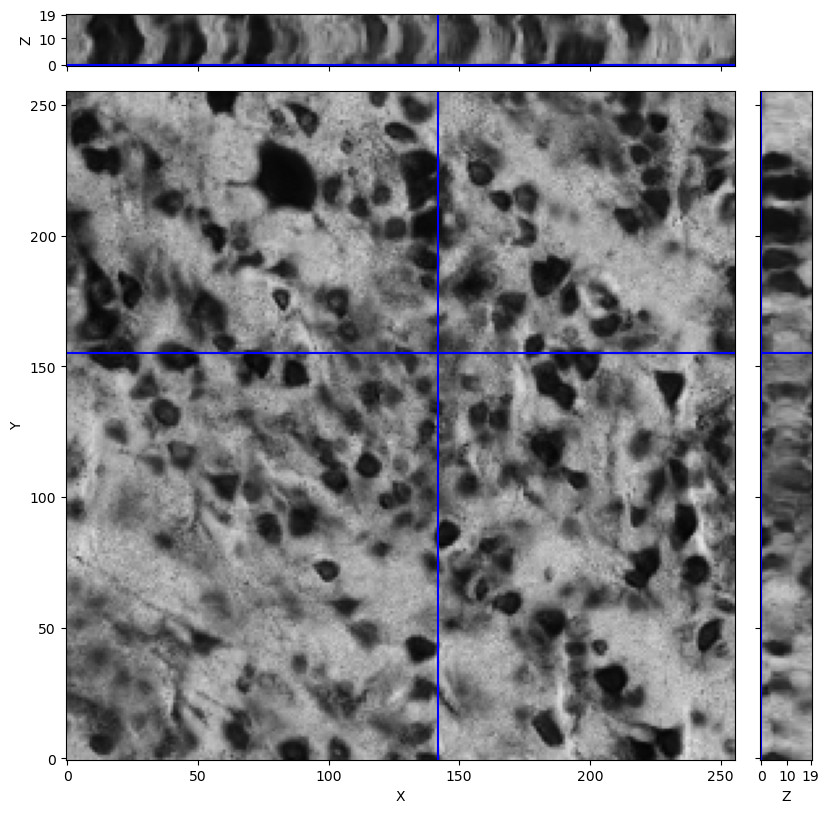

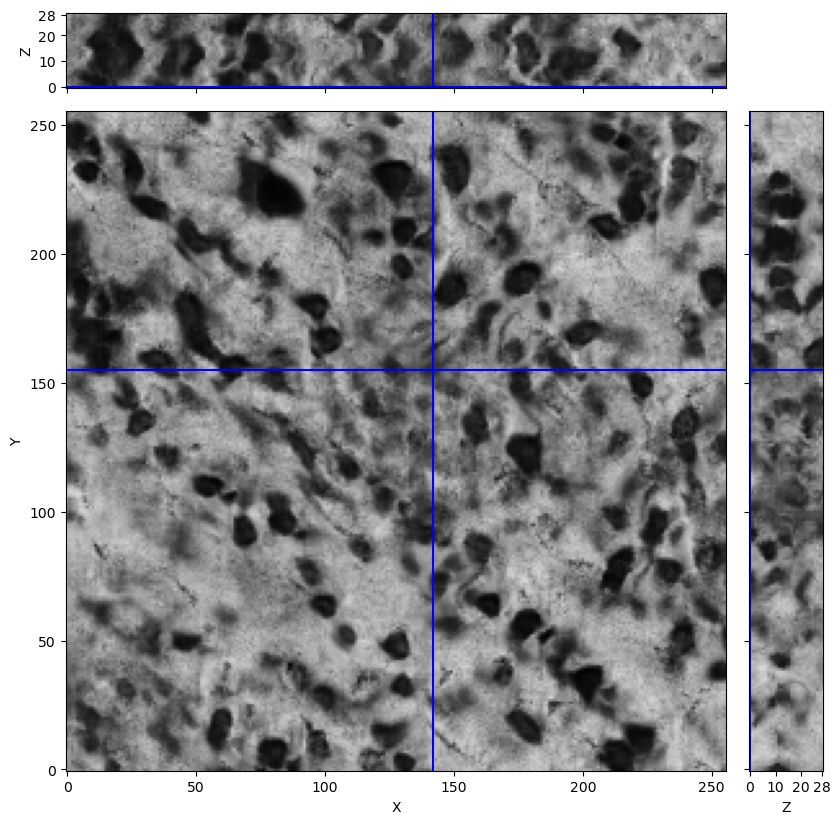

In [17]:
ckpt_path = f"{model_path}/brain/unet_3ds_best.ckpt"
gen_qualitative(ckpt_path, "unet", "unet_3d_small", 20, fname, stacks_20[fname], x, y, idx_20)
gen_qualitative(ckpt_path, "unet", "unet_3d_small", 29, fname, stacks_29[fname], x, y, idx_29)

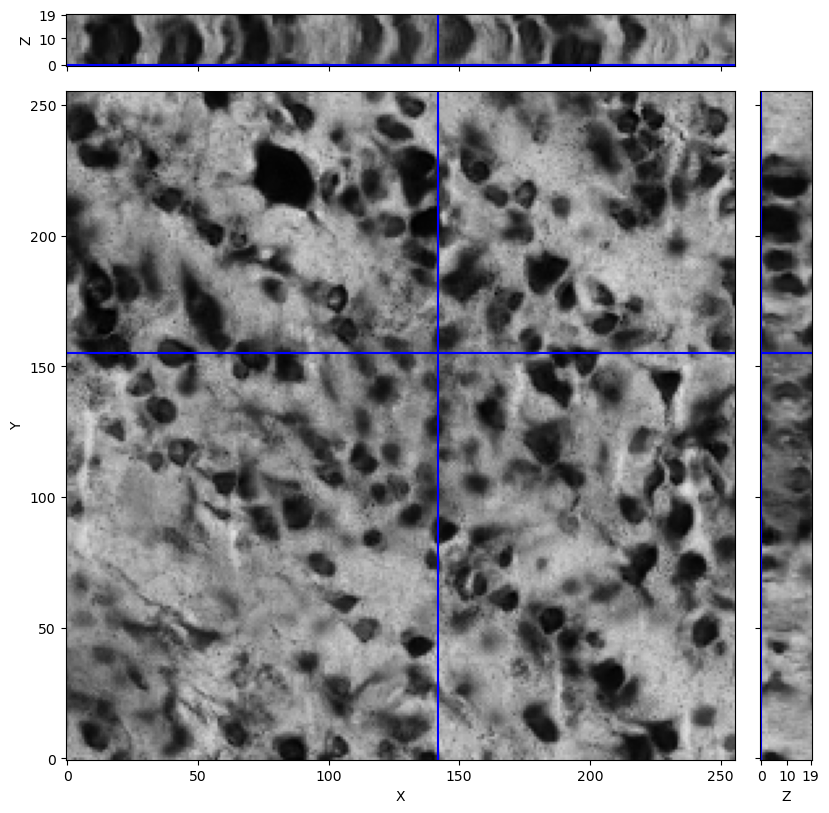

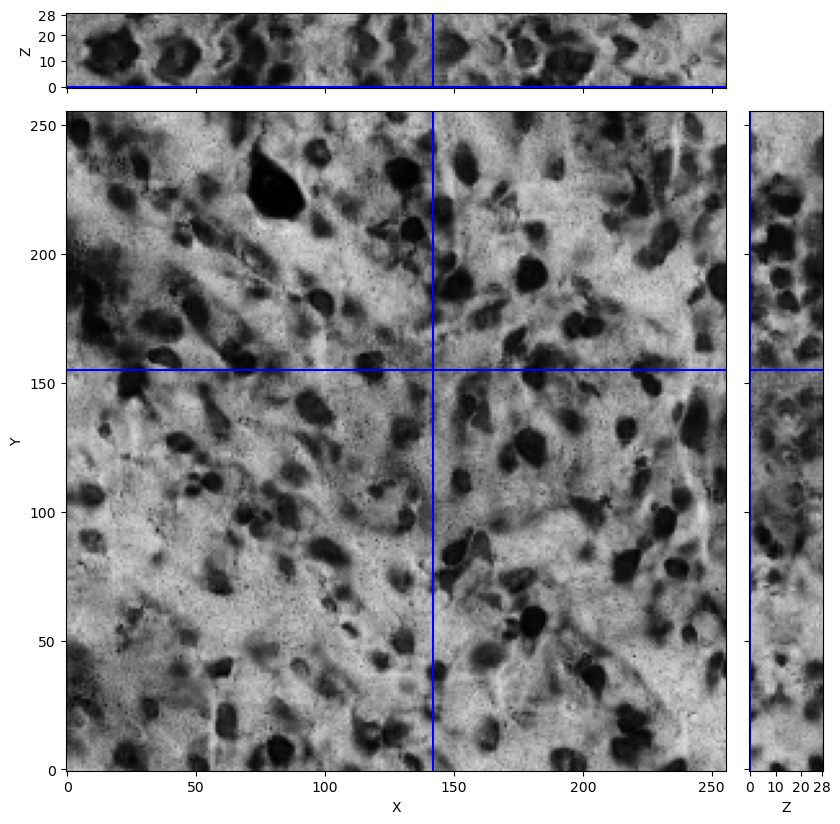

In [18]:
ckpt_path = f"{model_path}/brain/adain_unet_3ds_0pad_best.ckpt"
gen_qualitative(ckpt_path, "adain_unet", "adain_unet_3d_small_0p", 20, fname, stacks_20[fname], x, y, idx_20)
gen_qualitative(ckpt_path, "adain_unet", "adain_unet_3d_small_0p", 29, fname, stacks_29[fname], x, y, idx_29)